# How to Tackle a Machine Learning Competition


## Lecture 3: Overfitting revisited and Validation

Arianna Di Bernardo, arianna.dibernard@edu.unito.it



_______________________________________________________________________________________________________________________________
## Outline
Click on these links to jump to a particular section of this notebook.
- [1. Introduction, packages, prerequisites](#1)
- [2. Overfitting review](#2)
    - [2.1 Overfitting causes](#2-1)
    - [2.2 How to combact overfitting?](#2-2)
- [3. Validation](#3)
    - [3.1 Train, Validation, Test sets](#3-1)
    - [3.2 Validation strategies](#3-2)
    - [3.3 Data Splitting strategies](#3-3)
    - [3.4 Problems occurring during validation](#3-4)
- [4. References and additional materials](#4)


_______________________________________________________________________________________________________________________________
<a name='1'></a>
# 1. Introduction, packages and prerequisites

In this notebook we review some basic but essential concepts in machine learning: _**overfitting**_ and _**validation**_. 

In fact, when you design a ML algorithm, the main challenge is to avoid overfitting, a phenomenon that causes poor performance. Whit validation, one can keep track of the quality of the model, notice when it overfits and prevent the resulting bad solution.

In this lesson, we'll make use of the following packages:
- [numpy](https://docs.scipy.org/doc/numpy/), a popular library for scientific computing
- [matplotlib](https://matplotlib.org/3.1.1/contents.html), a plotting library compatible with numpy
- [pandas](https://pandas.pydata.org/docs/) is what we'll use to manipulate our data
- [sklearn](https://scikit-learn.org/stable/index.html) will be used to put into practice what we have seen in the theory 

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

Before you start with this notebook, make sure you are practical with basic commands in scikit learn and with the usual ML algorithms. 

Also we'll make use of some concepts seen in the first two notebooks of the series _How to Tackle a Machine Learning Competition:_ [Lecture1|FeatureProcessing](https://github.com/MLJCUnito/ProjectX2020/blob/master/HowToTackleAMLCompetition/Lecture1%7CFeatureProcessing.ipynb) and [Lecture2|EDA](link)



_______________________________________________________________________________________________________________________________
<a name='2'></a>
# 2. Overfitting review

**Overfitting** means _fitting the data more than is warranted._

It is the phenomenon where fitting the observed data well no longer indicates that we will get a good performance, and may actually lead to the opposite effect: in fact, many Machine Learning models have the ability to memorize the training set, which can lead to poor efficiency on unseen data.

In those cases, we obtain a model that perfectly approximates your data, but it doesn't have the ability to generalize to new examples.

The most important part when you design a model is recognizing overfitting and understanding the underlying causes, in order to combat it.  Remember: *Overfitting is your worst enemy!* 


 **Underfitting** is the opposite problem: it occurs when we fit data not enough, leading to bad approximation in addition to poor generalization.
 
 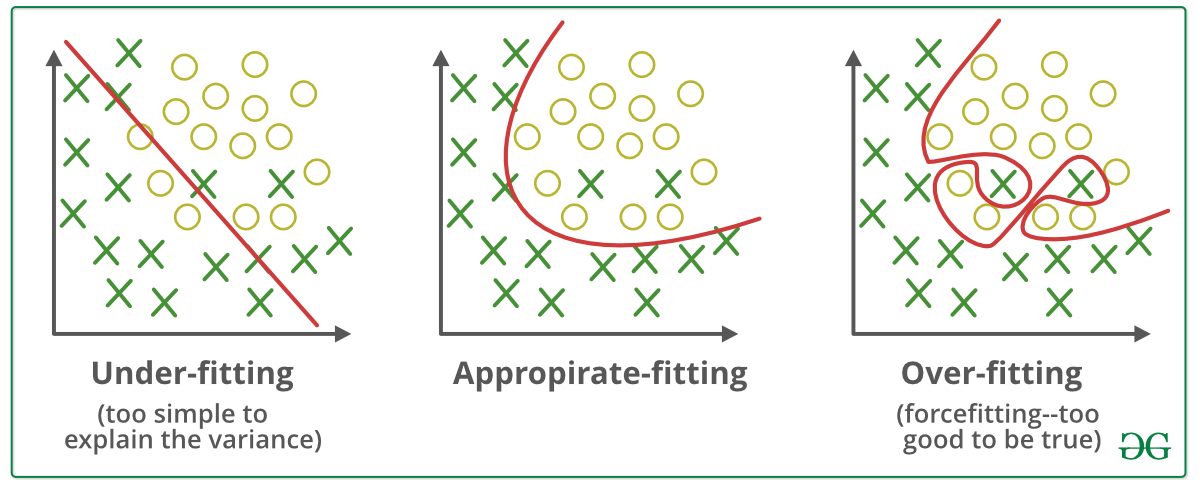
 
> So, to choose the best model, we basically want to avoid underfitting on the one side and overfitting on the other.



<a name='2-1'></a>
## 2.1 Overfitting causes

Let's start by identifying the causes of overfitting:

- Dataset size

- Stochastic noise

- Deterministic noise

**_Dataset size_** is the first culprit of overfitting: the fewer examples for training, the more models can fit our data. Consider an extreme example, a sample with only one training point: any model will be able to "explain" it!  As the training set size increases, fewer models are able to explain them, leading to decreased overfitting.

**_Stochastic noise_** is due to measurement errors or random fluctuations in your data. It is stochastic in the sense that it is random: each time we generate the sample, the stochastic noise is different. We cannot directly intervene to limit this kind of noise, it doesn't depend on the model and therefore on our choices.

**_Deterministic noise,_** in contrast, depends on the target function complexity and it is fixed for a given sample. It is the part of the target function which cannot be modeled: the learning algorithm shouldn't try to fit them, however it can't distinguish noise from the real signal.

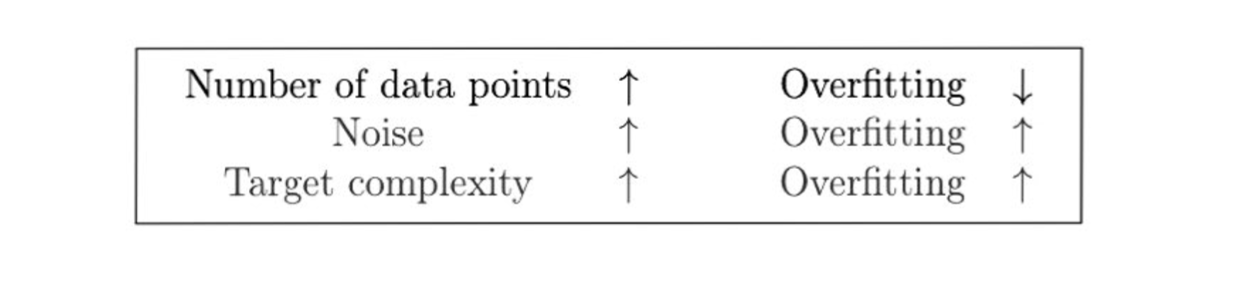

One can think to contrast noise (stochastic and deterministic) by using a complex model. But is that really the case? _**NO!**_

If the level of noise is high and the dataset is small, using a complex model makes it worse. In fact, _a complex model makes use of its additional degrees of freedom to fit noise,_ which can result in overfitting.


Let's understand this concept in a very simple example of a one dimensional regression problem with polynomials features.

- ### Example: polynomial fitting with linear regression ###

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
#generate the target function, ie the function to predict 
#to predict a function starting from data points is a ML problem, generally solved with linear regression

def target(X):
    return np.sin(2 *np.pi * X)        #deterministic noise is intrinsic in the target function complexity

In [4]:
degrees = [1, 3, 50]  #degrees of the models we will use

In [5]:
#generate the sample (the training set)

n_samples = 30    #dataset size

X = np.sort(np.random.rand(n_samples))    #generate random points
y = target(X) + np.random.randn(n_samples) * 0.1   #generate samples and add noise (what happens without noise?)

X_test = np.linspace(0, 1, 100)   #generate random points for testing our model. What will be the predictions for that points?

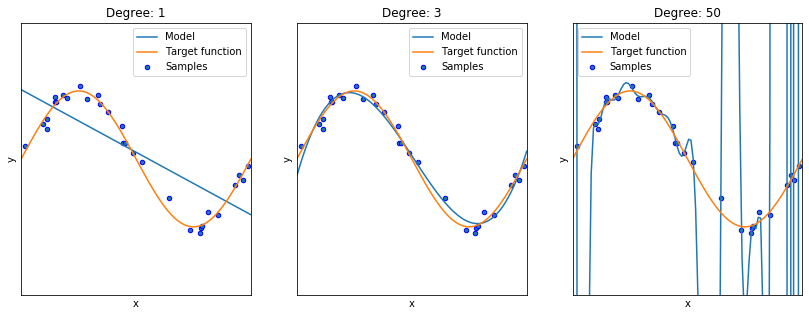

In [6]:
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],   #use polynomial features of given degree
                                             include_bias=False)
    linear_regression = LinearRegression()                             #use linear regression
    pipeline = Pipeline([("polynomial_features", polynomial_features),    #put all togheter
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)                               #fit the model

    
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")   #predicted function on the test set
    plt.plot(X_test, target(X_test), label="Target function")  #target function
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")   #plot data points
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree: {}".format(degrees[i]))

plt.show() 

In the picture above we can visualize the results of our model's predictions.

What we see is that a too simple model leads to underfitting: it can't capture underlined relationships and we will get poor results. 

Instead a complex model causes overfitting: in fact, the fitted curve passes exactly through each data point, but it oscillates wildly and gives a very poor representation of our target function. 

The compromise is a simple model of degree 3: it doesn't fit perfectly the target function, but it performs significantly better than the complex model of degree 50, that fits noise and is so far from our target function.

But does this mean that a simple model is always preferred to a complex model? Cleary not, in fact if you are dealing with a large dataset without noise, there is no reason to avoid a complex model.

Let's repeat the same procedure, but this time we make use of a dataset _without noise_.

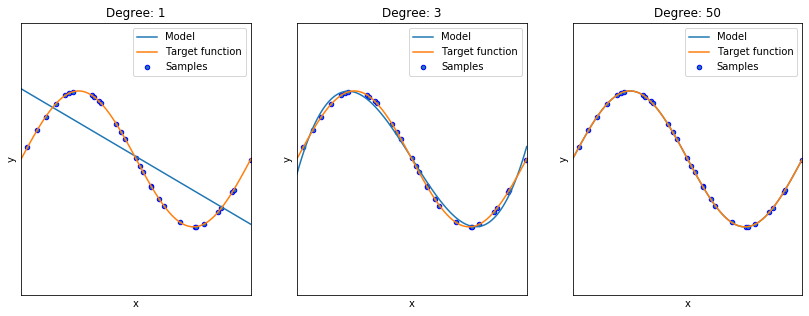

In [7]:
degrees = [1, 3, 50]

#generate the sample (the training set)

n_samples = 30    #dataset size

X = np.sort(np.random.rand(n_samples))    #generate random points
y = target(X)    #generate samples WITHOUT NOISE

X_test = np.linspace(0, 1, 100)   #generate random points for testing our model

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],   #use polynomial features of given degree
                                             include_bias=False)
    linear_regression = LinearRegression()                             #use linear regression
    pipeline = Pipeline([("polynomial_features", polynomial_features),    #put all togheter
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)                               #fit the model

    
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")   #predicted function on the test set
    plt.plot(X_test, target(X_test), label="Target function")  #target function
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")   #plot data points
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree: {}".format(degrees[i]))

plt.show() 

As you can see, in this case a complex model performs better than a simple one!

<a name='2-2'></a>
## 2.2 How to combact overfitting?

There are two ways to cure overfitting, often used together: _regularization_ and _validation_.

- With **regularization** one can put constraints to the learning process to improve the generalization performances of the model, and therefore its quality. The need and the amount of regularization depends on the quality and the quantity of your data: too much regularization can lead to underfitting, because the model is not free enough to fit the data well. In most of the models you will use, you can find the regularization term as hyperparameter.

- **Validation** allow you to keep an eye on the model performance, in order to prevent overfitting. This will be the argument of the next section of this notebook: [Validation](#3)

> Notice that the setting of optimal regularization parameters is done through validation!

<a name='3'></a>
# 3. Validation

To contrast overfitting we need to correctly understand the quality of our model, i.e. we _want to check if the model gives expected results on unseen data_.

The problem is that the performance of our model can differ on train data and on the test data, because the learning algorithm could just memorize all examples from the train data and be completely useless on unknown data.

So, usually, we divide the data we have available into two parts, train and validation part. We fit our model on the train part and check its quality on the validation part.

Only in this way we can select the model which will be expected to get the best quality on the test data, and adjust its hyperparameters (and often regularization is represented by one of these parameters): this could mean the choice between a linear or non linear model, the choice of the degree in a polynomial model, the choice of the value of a regularization parameter. 

> This step is called **model selection** and it is of paramount importance when you design a ML model: the goal is to select the best model and the optimal parameters for that model.

<a name='3-1'></a>
## 3.1 Train, Validation, Test sets

In this section we will show how validation works in a practical and interactive way. 

Let's introduce another useful dataset from [sklearn.datasets](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets): the _breast cancer wisconsin dataset,_ a classic and very easy binary classification dataset that is a collection of medical images of breast cancer together with their cancer characteristics.

In [8]:
from sklearn import datasets

In [9]:
dataset=datasets.load_breast_cancer()  # load dataset
pd.DataFrame(dataset.data, columns=dataset.feature_names)  # take a look at the dataset (patients images X features)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [10]:
list(dataset.target_names)   # take a look at the target (binary classification!)

['malignant', 'benign']

_Here you can proceed with EDA to take a look more in deep at the dataset, learned in the previous notebook (link)_

In [11]:
X, y = dataset.data, dataset.target  # create features and targets

Let's create our training and test set.

> Remember that the **training set** is used to learn the model, instead the **test set** is used to test the quality of your model, and in many ML competitions is hidden to participants

In [12]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=50)   # Split arrays into random train and test subsets

In [13]:
#import the models we will use 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [14]:
SV=SVC(random_state=0).fit(Xtrain, ytrain)    #train the model
SV.score(Xtrain, ytrain)   #calculate the score

C:\Users\arian\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0

Our model has learned the training examples perfectly! But is that really the case? Have we settled on a perfect classification scheme?

**_No!_**  To accurately measure the performance, we need to use a separate set of examples, which the model has not yet seen. Of course, this is the role of the test set... 

In [15]:
SV.score(Xtest, ytest)  

0.6293706293706294

The model is not able to generalize to new examples: this is the well known **OVERFITTING**!

In this case we learn two important things: first, the fact that the model gives accurate results on training examples, only means that it has learned perfectly the training examples, i.e. it fits perfectly our data, and it is okay. But it doesn't mean it will work equally well on new examples: it doesn't guarantee a good generalization. It's our job to find the right balance between approximation and generalization!

Second, the main rule you should know: **never use training examples to measure the quality of your model!** It produces a false prediction of the goodness of our work.

That’s what **validation** is for! 

With validation, one can immediately notice if your model is overfitting, and correct it in time.

The basic idea is to split the data with labels into two parts, one is used for the training itself, the other for validation.
Validation set try to reproduce the test set, but this time, you can use the resulting information to correct the model!
(generally you can't do this with the real test set, often it is unknown, mostly in ML competition)


Let's do it!

In [16]:
#apply another time train_test split, this time in order to split in training and validation
train_x, valid_x, train_y, valid_y = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=20) 
len(train_x), len(valid_x)  

(340, 86)

In [17]:
SV=SVC(random_state=0).fit(train_x, train_y)    #train the model with the training set
SV.score(valid_x, valid_y)   #calculate the score with the validation set

C:\Users\arian\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.627906976744186

We can notice in time that this model is not too good, and avoid using it!

Let's try with other models... (this is the _model selection_ step)

In [18]:
RF=RandomForestClassifier(random_state=0).fit(train_x, train_y)
RF.score(valid_x, valid_y)   

C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9767441860465116

In [19]:
clf = LogisticRegression(random_state=0).fit(train_x, train_y) 
clf.score(valid_x, valid_y)

C:\Users\arian\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9534883720930233

In [20]:
DT=DecisionTreeClassifier(random_state=0).fit(train_x, train_y)  
DT.score(valid_x, valid_y)

0.9418604651162791

In [21]:
NB=GaussianNB().fit(train_x, train_y)   
NB.score(valid_x, valid_y) 

0.9418604651162791

In [22]:
MLP=MLPClassifier(random_state=0).fit(train_x, train_y)   
MLP.score(valid_x, valid_y) 

C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.9302325581395349

And the winner is... Random Forest Classifier! We can now stay safe and use this classifier to perform our binary classification on the breast cancer dataset.

> Notice that these validation schemes are supposed to be used to estimate the quality of the model. When you've found the right model and hyper-parameters and want to get test predictions, ***don't forget to retrain your model using all training data.***

In [23]:
#retrain the model with the entire dataset
final_model=RandomForestClassifier(random_state=0).fit(Xtrain, ytrain)
final_model.score(Xtest, ytest)  #the final evaluation

C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9300699300699301

We have correct overfitting (almost) by using a different model.

Another crucial step in model selection is *hyperparameter tuning*, that consists in adjusting the intrinsic parameters that characterize each model. You will see in detail this theme in a future lesson.

Finally, let's recap the basic concepts seen in this section:
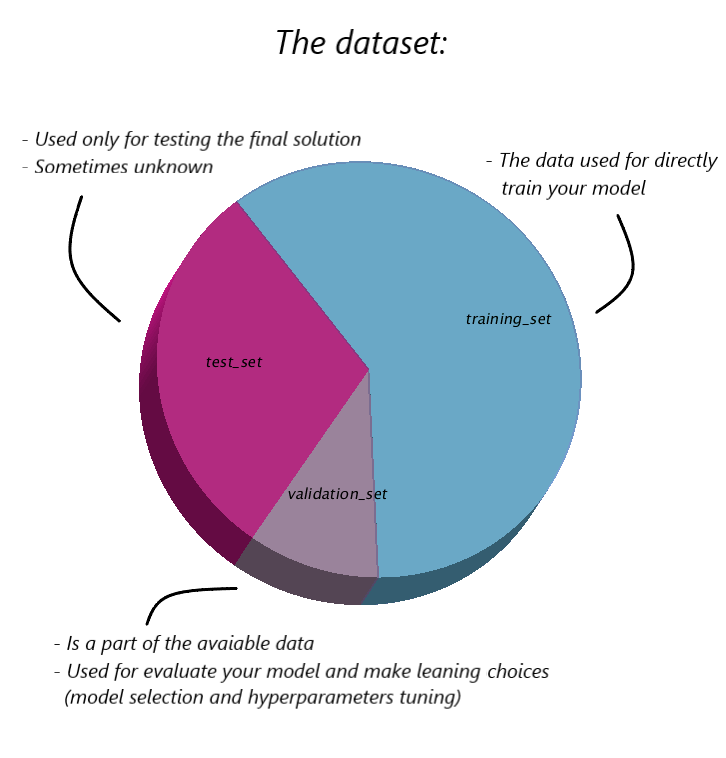

> An important thing to keep in mind when splitting your dataset in train and validation parts is that samples between train and validation must not overlap: if we evaluate our model with an example yet seen, the performance of the model increases, but we well know that is not a good thing.
This is sometimes the case when we have repeated samples in the data: be aware to exclude duplicates before starting the training and validation steps!

<a name='3-2'></a>
## 3.2 Validation strategies

The way to split our dataset we just saw is called **HOLD OUT** strategy:

it divides data into two parts. Training part is used to fit our model, the validation part to evaluate its performance. Using the scores from this evaluation step, we can choose the best model and the best hyperparameters for the selected model.

If we have enough data, using holdout is usually a good choice. In particular we can use this scheme if we get similar scores for the same model when we try different Hold-out splits. 

_But what is the optimal size of our sets?_

> A common split is using 80% of data for training and the remaining 20% of the data for testing.

Another useful command you can use is [sklearn.model_selection.ShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) (this method just splits the data into one training and one validation set)


Let's now introduce some other useful strategies to split data, and focus on the reasons to use each one of them.

### Leave-One-Out cross validation

If your dataset is small, it makes sense the validation set is small, in order to save enough examples for the training. But this means that the validation error will be a bad estimation of the test error, because a too little validation set doesn't capture the behaviour of the test set.

To measure the performance of your model with only one example is too constrictive.

The solution is the **leave-one-out** stategy: in that scheme we iterate through every sample in our data, each time using one example for validation and the remaining examples for training. You will need to retrain the model N times (if N is the number of samples in the dataset).

In the end you will get predictions for every sample in the training set and can calculate the loss by average the single losses  (this averaging process is called _cross validation_ ).

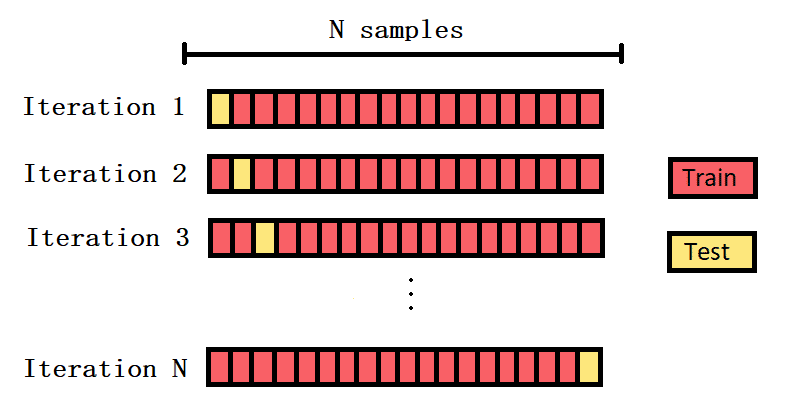

This method can be helpful if we have too little data and just enough model to choose from.

In scikit-learn there exist a function able to to this:  [sklearn.model_selection.LeaveOneOut](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut)


In [24]:
from sklearn.model_selection import LeaveOneOut

For example, let's consider a very small dataset, with only 10 examples:

In [25]:
from sklearn.datasets import make_classification

# define the dataset
X_clf, y_clf = make_classification(n_samples=10, n_features=4, random_state=3)

# summarize the dataset
print(X_clf.shape, y_clf.shape)

(10, 4) (10,)


Text(0.5, 1.0, 'Data')

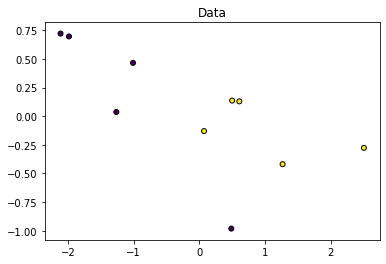

In [26]:
plt.scatter(X_clf[:, 0], X_clf[:, 1], marker='o', c=y_clf,
            s=25, edgecolor='k')
plt.title("Data")

In [27]:
loo = LeaveOneOut()
loo.get_n_splits(X_clf)   #Returns the number of splitting iterations in the cross-validator

10

In [28]:
loo.split(X_clf)

<generator object BaseCrossValidator.split at 0x000001DBFF453948>

In [29]:
#try with a naive bayes classifier
from  numpy import mean, std
score=[]

from sklearn.naive_bayes import GaussianNB
NB2=GaussianNB()  

for train_index, valid_index in loo.split(X_clf):     #Generate indices to split data into training and test set.
     print("TRAIN:", train_index, "VALID:", valid_index)
     X_train, X_valid = X_clf[train_index], X_clf[valid_index]
     y_train, y_valid = y_clf[train_index], y_clf[valid_index]
     NB2.fit(X_train, y_train)
     print(NB2.score(X_valid, y_valid))
     score.append(NB2.score(X_valid, y_valid))
print("Accuracy: %0.2f (+/- %0.2f)" % (mean(score), std(score) * 2))   #Average accuracy with cross validation

TRAIN: [1 2 3 4 5 6 7 8 9] VALID: [0]
1.0
TRAIN: [0 2 3 4 5 6 7 8 9] VALID: [1]
0.0
TRAIN: [0 1 3 4 5 6 7 8 9] VALID: [2]
1.0
TRAIN: [0 1 2 4 5 6 7 8 9] VALID: [3]
1.0
TRAIN: [0 1 2 3 5 6 7 8 9] VALID: [4]
1.0
TRAIN: [0 1 2 3 4 6 7 8 9] VALID: [5]
1.0
TRAIN: [0 1 2 3 4 5 7 8 9] VALID: [6]
0.0
TRAIN: [0 1 2 3 4 5 6 8 9] VALID: [7]
1.0
TRAIN: [0 1 2 3 4 5 6 7 9] VALID: [8]
1.0
TRAIN: [0 1 2 3 4 5 6 7 8] VALID: [9]
1.0
Accuracy: 0.80 (+/- 0.80)


### K-fold cross validation

K-Fold divides data in K groups of samples of equal size, called folds (if K=size of training, this is equivalent to the Leave One Out strategy). The prediction function is learned using K-folds, and the fold left out is used as a validation set _only once._ After this procedure, we average scores over these K-folds (cross validation step). 

This method is a good choice when we have enough data and we can get different scores and optimal parameters for different splits. 

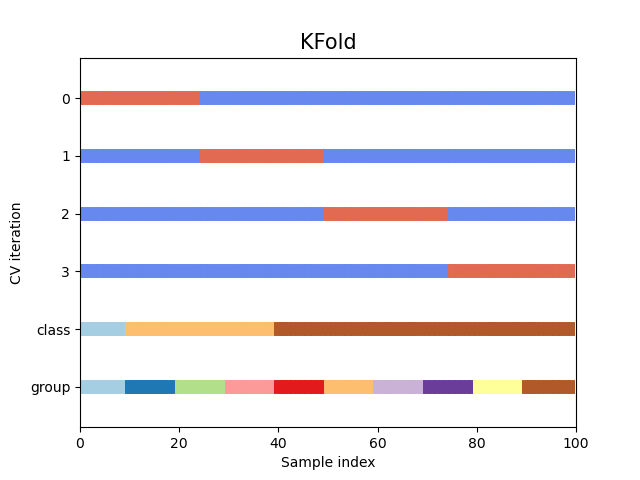

You can also estimate mean and variance of the loss. This is very helpful in order to understand the significance of improvement.

> Here it is important to understand the difference between K-fold and a K-repeated hold-out. In the first case it is possible to average the scores in order to obtain a mean score indicating the quality of the model. In the second case, you can't: some samples may never get in validation, while others can be there multiple times. An average of the score is no longer informative.

Let's apply this strategy to our cancer breast classification problem and select the best classifier in this way.

Useful commands are [sklearn.model_selection.KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), that provides train/test indices to split data in train/test sets, and [sklearn.model_selection.cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), for evaluating the scores by cross-validation. We will use this second one command.

In [30]:
from sklearn.model_selection import cross_val_score

for clf in [SVC(random_state=0), RandomForestClassifier(random_state=0), GaussianNB(), DecisionTreeClassifier(random_state=0), 
             LogisticRegression(random_state=0), MLPClassifier(random_state=0)]:
    model = clf
    scores = cross_val_score(model, Xtrain, ytrain, cv=5)

    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\arian\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: 

Accuracy: 0.63 (+/- 0.01)


C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default so

Accuracy: 0.95 (+/- 0.05)
Accuracy: 0.93 (+/- 0.06)
Accuracy: 0.92 (+/- 0.06)
Accuracy: 0.94 (+/- 0.10)


C:\Users\arian\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy: 0.94 (+/- 0.06)


This time, the winner is random forest classifier, and it is a more conscious and precise choice.

<a name='3-3'></a>
## 3.3 Data Splitting strategies

Validation strategies we have just seen are holdout, leave-one-out cross validation and K-fold cross validation, and the main difference between them is the number of splits being done. 

The main idea when you are dealing with a ML competition is that we absolutely want to identify train/test split made by organizers in order to reproduce it with the train/validation split.

Let's now summarize some splitting strategies and focus on some concepts to keep in mind when splitting the dataset in training and validation sets.

- ## Random split
Let's start with the most common way of making a train-validation split: split data randomly. 
Because the objects in a dataset are represented by rows (vectors of features), this is equivalent to splitting randomly the dataset by rows, and this usually means that the rows are independent of each other. 

> ###  Random split vs stratification

> Sometimes, especially if you do not have enough samples for some class, if you are involved with unbalanced data sets or if you are dealing with multiclass classification tasks, a random split can fail. In fact, obtaining different distributions in different splits can drastically change predictions of our model. 
What we need here to handle this problem is _stratification._ It is just the way to enquire similar distribution over different faults. This split is made by preserving the percentage of samples for each class and not totally random.
You can perform this kind of validation with scikit learn commands [sklearn.model_selection.StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

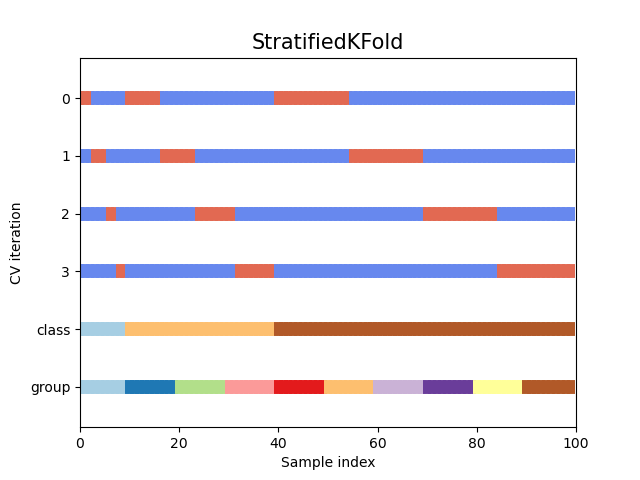

- ## Time based split

The goal of time series forecasting is to make accurate predictions about the future.

When we are dealing with time series (or other data that shows temporal structure), we need to rely on the time trend instead of randomly picking up values. In fact, when performing classical hold-out or k-fold cross validation, the temporal components of the data are ignored, resulting in poor performances of the model.
The strategies seen so far do not work in the case of time series data. 

Since our observations are not independent, what we need is to split observations along with the sequences we can make a _time-based split,_ take everything before some date as a train and everything out there as a validation (then it is similar to Hold-out strategy. But this time without ignoring the temporal correlation between data). 

A special case of validation for the time-based split is a moving window validation: we can move the date which divides train and validation. Successively using week after week, or year after year, as a validation set and at the end averaging the resulting scores. 

In scikit-learn you can find the usefull command [sklearn.model_selection.TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

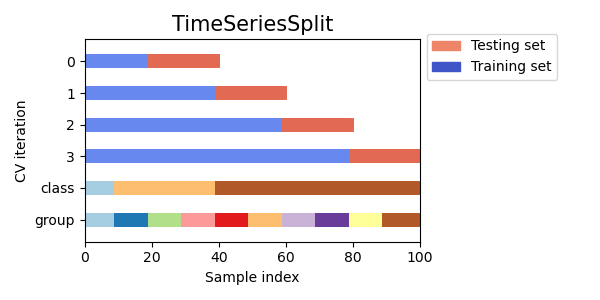

Let's try to implement a very simple example.

- ### Heat index prediction 

The Heat Index is a measure of how hot is really feels when relative humidity is factored in with the actual air temperature. ([National Weather Service page](https://www.weather.gov/ama/heatindex#:~:text=The%20heat%20index%2C%20also%20known,sweat%20to%20cool%20itself%20off.))

To determine the heat index using the chart above, you need to know the air temperature and the relative humidity.

Suppose we are dealing with a multiclassification task: at each Heat Index corresponds a critical situation, summarized with a qualitative value: caution, extreme caution, danger, extreme danger.

Labels for the multiclassification task: 
- caution - 1
- extreme caution -2 
- danger - 3
- extreme danger - 4

In [31]:
#dataset and labels creation

X = np.array([[60, 80], [65, 82], [55, 92], [55, 96], [60, 102], [65, 96], [55,94]])  
y = np.array([1, 1, 2, 3, 4, 3, 3])

df=pd.DataFrame(X)
df.columns=['relative humidity (%)', 'temperature (°F)']
df

,relative humidity (%),temperature (°F)
0,60,80
1,65,82
2,55,92
3,55,96
4,60,102
5,65,96
6,55,94


In [32]:
#let's create the test set: the two days after..
#dataset and label creation

Xtest = np.array([[60, 100], [55, 112]])  
ytest = np.array([4, 3])

In [33]:
from sklearn.model_selection import TimeSeriesSplit

for train_index, valid_index in TimeSeriesSplit(n_splits=6).split(X):  #max_train_size=None, 
    print("TRAIN:", train_index, "VALID:", valid_index)
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    
    RF3=RandomForestClassifier(random_state=0).fit(X_train, y_train)
    print('prediction:', RF3.predict(X_valid))
    print('ground truth:', y_valid)
    print('accuracy:', RF3.score(X_valid, y_valid))

TRAIN: [0] VALID: [1]
prediction: [1]
ground truth: [1]
accuracy: 1.0
TRAIN: [0 1] VALID: [2]
prediction: [1]
ground truth: [2]
accuracy: 0.0
TRAIN: [0 1 2] VALID: [3]
prediction: [2]
ground truth: [3]
accuracy: 0.0
TRAIN: [0 1 2 3] VALID: [4]
prediction: [3]
ground truth: [4]
accuracy: 0.0
TRAIN: [0 1 2 3 4] VALID: [5]
prediction: [3]
ground truth: [3]
accuracy: 1.0
TRAIN: [0 1 2 3 4 5] VALID: [6]
prediction: [2]
ground truth: [3]
accuracy: 0.0


C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\arian\anaconda\lib\site-packages\sklearn\ensemble\forest.py:245: Future

In [34]:
print('prediction:', RF3.predict(Xtest))
print('ground truth:', ytest)
print('accuracy:', RF3.score(Xtest, ytest))

prediction: [4 3]
ground truth: [4 3]
accuracy: 1.0


- ## ID-based split

ID can be a unique identifier of objects: patients, authors, users on a social network, shops or any other entity. That means, we have different sets of users in train and test; in this way one can also prevent train-validation overlap.

For example, if you are dealing with a medical task involving the analysis of a set of images, it is important that the validation set doesn't contain images of a patient used for training: this could result in an unbiased evaluation of your model in the validation step.

You can use the command [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) from sklearn.

In [35]:
from sklearn.model_selection import GroupShuffleSplit
X=np.random.rand(8,2)
y=(X[:,0]+X[:,1]).astype(int)
ID = np.array([1, 1, 2, 2, 2, 3, 3, 3])  #let's create ID

In [36]:
d = {'X_1': X[:,0], 'X_2': X[:,1], 'label': y, 'ID': ID}
df = pd.DataFrame(data=d)
df.set_index('ID')

,X_1,X_2,label
ID,,,
1,0.846685,0.301686,1
1,0.583217,0.048513,0
2,0.645507,0.268371,0
2,0.386941,0.506717,0
2,0.350901,0.215241,0
3,0.617227,0.531666,1
3,0.727490,0.372220,1
3,0.858088,0.741688,1


In [37]:
gss = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
gss.get_n_splits()

for train_idx, valid_idx in gss.split(X,y,ID):
   print("TRAIN INDEX:", train_idx, ", which IDs are", ID[train_idx], "; VALID:", valid_idx, ", which IDs are", ID[valid_idx],)

TRAIN INDEX: [2 3 4 5 6 7] , which IDs are [2 2 2 3 3 3] ; VALID: [0 1] , which IDs are [1 1]
TRAIN INDEX: [0 1 5 6 7] , which IDs are [1 1 3 3 3] ; VALID: [2 3 4] , which IDs are [2 2 2]


Notice that train and validation sets cointain examples with IDs not overlapping.

<a name='3-4'></a>
## 3.4 Problems occurring during validation 

Let's summarize the problems you can meet when performing the validation step:

_**Get different optimal parameters for different faults**_ and  _**obtain difference in scores for different train validation splits.**_

We can identify two main reasons for this:

1. _Having too little data:_ if we have a lot of patterns but we do not have enough samples to generalize these patterns well, the model will utilize only some general patterns. And for each train validation split, these patterns will partially differ, resulting in different scores. 

2. _Data is too diverse and inconsistent:_ if you have very similar samples with different target variance, a model can confuse them.

> What can we do to contain these problems? 
- You can increase the number of folds (but usually 5 folds are enough);
- You can perform the validation strategy you choose several times, with different random splits and average scores to get a more stable estimate of model's quality;
- Also it is useful to use one set of splits to select parameters, and another to check the model's performance. 

<a name='4'></a>
# 4. References and additional materials

- 'Learning From Data, a short course', Hsuan-Tien Lin, Yaser S. Abu-Mostafa, Malik Magdon-Ismail  (cap 4)

- [How to Select Your Final Models in a Kaggle Competition](http://www.chioka.in/how-to-select-your-final-models-in-a-kaggle-competitio/)

- [validation stategies: visualization in scikit-learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html)

- [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science)
